<div align="center"

## 다음에 볼 영화 예측하기(Movielens 영화 SBR)
</div>

: Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템 제작해보기.

**라이브러리 버전 확인 및 데이터 확인**

In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
! ls -l ~/data

total 1893592
-rwxrwxrwx 1 root root       3973 Dec 21 15:32 dataset-README.txt
-rwxrwxrwx 1 root root     171308 Dec 21 15:32 movies.dat
-rwxrwxrwx 1 root root   24594131 Dec 21 15:33 ratings.dat
-rwxrwxrwx 1 root root       5577 Dec 21 15:32 README
drwxr-xr-x 5 root root       4096 Feb 23 05:48 trained_model
-rwxrwxrwx 1 root root     134368 Dec 21 15:32 users.dat
-rwxrwxrwx 1 root root   55583744 Dec 21 15:32 yoochoose-buys.dat
-rwxrwxrwx 1 root root 1486798186 Dec 21 15:32 yoochoose-clicks.dat
-rwxrwxrwx 1 root root  371725851 Dec 21 15:33 yoochoose-test.dat


In [3]:
! mkdir -p ~/aiffel/yoochoose

In [4]:
! ln -s ~/data/* ~/aiffel/yoochoose/data

ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/dataset-README.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/movies.dat': File exists
ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/ratings.dat': File exists
ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/README': File exists
ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/trained_model': File exists
ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/users.dat': File exists
ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/yoochoose-buys.dat': File exists
ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/yoochoose-clicks.dat': File exists
ln: failed to create symbolic link '/aiffel/aiffel/yoochoose/data/yoochoose-test.dat': File exists


**Importing the libraries**

In [5]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

**Load the dataset**

In [6]:
data_path = Path(os.getenv('HOME') + '/aiffel/yoochoose/data/')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3],
                       dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True) # 데이터를 Id와 시간 순으로 정렬.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있다. 그러므로  UserID가 SessionID 역할을 해야한다.
- Rating 정보가 포함되어 있다. 이 정보는 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있을 뿐만아니라, Rating이 낮은 데이터를 어떻게 처리할지도 고민해봐야 한다.
- Time 항복에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있다.

### 1. 데이터 전처리

**User Length**

In [7]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [8]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [9]:
user_length.min(), user_length.max()

(20, 2314)

In [10]:
user_length.quantile(0.99)

906.659999999998

In [11]:
data.nunique()

UserId      6040
ItemId      3706
Rating         5
Time      458455
dtype: int64

In [12]:
data.isnull().sum()

UserId    0
ItemId    0
Rating    0
Time      0
dtype: int64

In [13]:
print(data['Rating'].unique())

[4 5 3 2 1]


총 6040명의 유저와 3706개의 아이템이 있고, 99% 유저의 길이는 906 이하이다.
<br>
유저 한 명당 평균 165개의 영화를 평가하였으며, 평점은 1~5까지 총 5가지의 범주형 형태로 있으며, 결측치는 존재하지 않는다.
<br>
추가로 한 명의 유저가 최대 2314의 길이를 갖었는데 이 부분은 확인해 볼 필요가 있다.

In [14]:
long_userid = user_length[user_length==2314].index[0]
data[data['UserId']==long_userid]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


**userid 기준 길이 하위 99%까지의 누적 분포 합 시각화**

In [23]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.99]

length_percent_cumsum_99

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
888    0.989073
893    0.989404
894    0.989570
900    0.989735
903    0.989901
Length: 684, dtype: float64

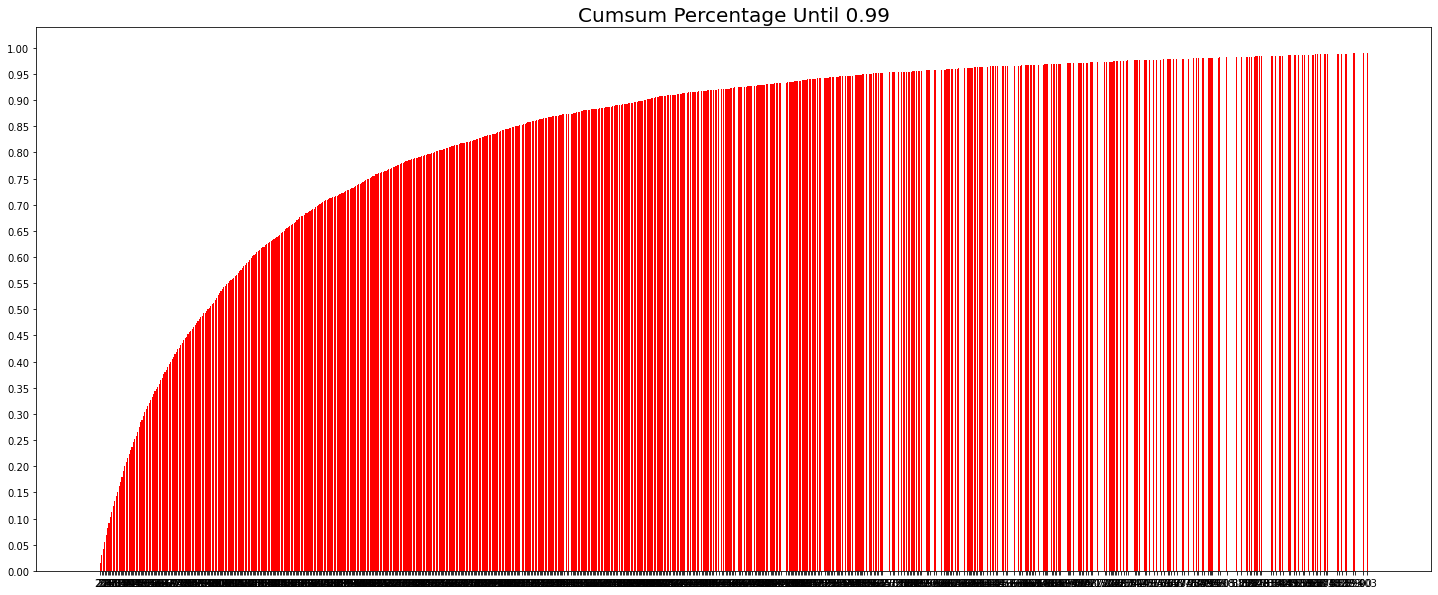

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))
plt.bar(x=length_percent_cumsum_99.index,
        height=length_percent_cumsum_99, color='red')
plt.xticks(length_percent_cumsum_99.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

In [32]:
length_percent_cumsum_10 = length_percent_cumsum[length_percent_cumsum > 0.99]
length_percent_cumsum_10

909     0.990066
914     0.990232
915     0.990397
920     0.990563
923     0.990728
928     0.990894
934     0.991060
939     0.991391
941     0.991556
947     0.991722
955     0.991887
957     0.992053
962     0.992219
964     0.992384
967     0.992550
971     0.992715
982     0.992881
990     0.993046
999     0.993212
1000    0.993377
1004    0.993543
1006    0.993709
1009    0.993874
1014    0.994040
1016    0.994205
1018    0.994371
1019    0.994536
1024    0.994702
1038    0.994868
1047    0.995033
1050    0.995199
1078    0.995364
1115    0.995530
1144    0.995695
1152    0.995861
1158    0.996026
1169    0.996192
1176    0.996358
1211    0.996523
1216    0.996854
1220    0.997020
1222    0.997185
1226    0.997351
1240    0.997517
1243    0.997682
1258    0.997848
1260    0.998013
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
1344    0.999007
1518    0.999172
1521    0.999338
1595    0.999503
1743    0.999669
1850    0.999834
2314    1.0000

In [33]:
length_percent_cumsum_10.mean()

0.9950695925468628

userid기준 상위 1%의 유저는 3년 동안 평균 995편의 영화를 봤다. 세션을 기준으로 추천을 해줄 계획이기 때문에 이 데이터도 드랍시키지 않을 예정이다.

**Session Time**

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


In [19]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   UserId  1000209 non-null  int32         
 1   ItemId  1000209 non-null  int32         
 2   Rating  1000209 non-null  int32         
 3   Time    1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3)
memory usage: 26.7 MB


In [21]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


데이터는 대략 3년치 데이터가 존재한다. 영화는 패션이나 뷰티 같이 시대를 계절성이나 시간의 영향을 크게 받지 않기 때문에 3년치 데이터를 그대로 사용할 예정이다.

**Data Cleansing**

In [38]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_view) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_view)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [39]:
user_len = data.groupby('UserId').size()
item_popular = data.groupby('ItemId').size()

print(user_len.mean())
print(item_popular.mean())

165.5975165562914
269.88909875876953


In [43]:
data = cleanse_recursive(data, shortest=5, least_view=2)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


1번만 시청된 영화는 제거

**Train/ Valid/ Test split**

In [44]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max().sort_values()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    
    before_date = user_in_train
    after_date = user_in_test
    return before_date, after_date

In [45]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [46]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [47]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 978986
	 Users: 6038
	 Items: 3592
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:19:56

* valid Set Stats Info
	 Events: 12289
	 Users: 399
	 Items: 2624
	 First Time : 2002-03-05 04:21:07
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 8820
	 Users: 339
	 Items: 2330
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



- test set: 마지막 6개월
- valid set: 6개월
- train set: 나머지 기간 전체

In [48]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [49]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### 2. 미니배치 구성

Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있다.

**SessionDataset**

In [50]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [53]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [54]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 978522, 978645, 978986], dtype=int32)

In [55]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

**SessionDataLoader**

In [56]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [57]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=5)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [58]:
iter_ex = iter(tr_data_loader)

In [59]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54 56]
Label Item Idx are :       [  1  54  62  24 218]
Previous Masked Input Idx are []


### 3. Modeling

**Evaluation Metric**

In [61]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

**Model Architecture**

모델의 구조가 간단하므로 functional하게 모델을 만들 예정.

In [60]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [62]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [63]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [66]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3592)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    546600    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3592)               183192    
Total params: 729,792
Trainable params: 729,792
Non-trainable params: 0
_________________________________________________________________


### 4. 모델 학습

In [67]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
#         pred_arg = tf.nn.top_k(pred, k=124, sorted=True)[1]  # softmax 값이 큰 순서대로 sorting 합니다.
        pred_arg = tf.argsort(pred, direction='DESCENDING')
    
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [69]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3592)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    546600    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3592)               183192    
Total params: 729,792
Trainable params: 729,792
Non-trainable params: 0
_________________________________________________________________


In [70]:
# args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
# model = create_model(args)
train_model(model, args)

Evaluation:  15%|█▌        | 7/46 [00:08<00:47,  1.21s/it]


	 - Recall@20 epoch 1: 0.072545
	 - MRR@20    epoch 1: 0.015815



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.11s/it]


	 - Recall@20 epoch 2: 0.102679
	 - MRR@20    epoch 2: 0.028892



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.11s/it]


	 - Recall@20 epoch 3: 0.113281
	 - MRR@20    epoch 3: 0.034589



Evaluation:  15%|█▌        | 7/46 [00:07<00:41,  1.08s/it]


	 - Recall@20 epoch 4: 0.117746
	 - MRR@20    epoch 4: 0.035625



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.08s/it]

	 - Recall@20 epoch 5: 0.120536
	 - MRR@20    epoch 5: 0.037277



In [81]:
args_downbatch = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.05, lr=0.001, epochs=5, k=25)
model_downbatch = create_model(args_downbatch)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(64, 1, 3592)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      546600    
_________________________________________________________________
dropout_6 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_6 (Dense)              (64, 3592)                183192    
Total params: 729,792
Trainable params: 729,792
Non-trainable params: 0
_________________________________________________________________


In [82]:
train_model(model_downbatch, args_downbatch)

Evaluation:  67%|██████▋   | 124/185 [00:44<00:21,  2.81it/s]


	 - Recall@25 epoch 1: 0.126134
	 - MRR@25    epoch 1: 0.030363



Evaluation:  67%|██████▋   | 124/185 [00:43<00:21,  2.84it/s]


	 - Recall@25 epoch 2: 0.145791
	 - MRR@25    epoch 2: 0.036008



Evaluation:  67%|██████▋   | 124/185 [00:43<00:21,  2.87it/s]


	 - Recall@25 epoch 3: 0.153478
	 - MRR@25    epoch 3: 0.039545



Evaluation:  67%|██████▋   | 124/185 [00:43<00:21,  2.85it/s]


	 - Recall@25 epoch 4: 0.157636
	 - MRR@25    epoch 4: 0.041032



Evaluation:  67%|██████▋   | 124/185 [00:42<00:21,  2.89it/s]

	 - Recall@25 epoch 5: 0.157384
	 - MRR@25    epoch 5: 0.041284



### 5. 추론

In [71]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [72]:
test_model(model, args, test)

Evaluation:   6%|▌         | 2/33 [00:02<00:33,  1.08s/it]

	 - Recall@20: 0.111328
	 - MRR@20: 0.038544



In [83]:
test_model(model_downbatch, args_downbatch, test)

Evaluation:  59%|█████▉    | 78/132 [00:23<00:16,  3.33it/s]

	 - Recall@25: 0.158854
	 - MRR@25: 0.047584



### 6. 회고

: 그리드 서치를 통해 모델의 하이퍼 파라미터 튜닝을 하려고 시도하였으나 시간이 너무 많이 걸리는 관계로 일단 먼저 추론을 진행하였다. 추가로 그리드 서치로 하이퍼 파라미터를 서치해서 추론을 해 볼 예정이다.